In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    ONE_AND_HALF_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [3]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from src.sorted_spikes_simulation import (
    make_continuous_replay,
    make_fragmented_continuous_fragmented_replay,
    make_fragmented_hover_fragmented_replay,
    make_fragmented_replay,
    make_hover_continuous_hover_replay,
    make_hover_replay,
    make_simulated_run_data,
    TRACK_LENGTH,
    PLACE_FIELD_MEANS,
)

(
    time,
    linear_distance,
    sampling_frequency,
    spikes,
    place_fields,
) = make_simulated_run_data()

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

classifier = SortedSpikesClassifier(
    movement_var=movement_var,
    replay_speed=120,
    spike_model_penalty=0.5,
    place_bin_size=np.sqrt(movement_var),
    discrete_transition_diag=0.98,
)
classifier.fit(linear_distance, spikes)

SortedSpikesClassifier(discrete_transition_diag=0.98,
                       movement_var=0.2775841643294236,
                       place_bin_size=0.5268625668325884, replay_speed=120,
                       spike_model_penalty=0.5)

In [174]:
from replay_trajectory_classification.simulate import simulate_time


def get_constant_velocity_replay(
    velocity,  # m/s
    start_position=0.0,
    track_length=TRACK_LENGTH,
    place_field_means=PLACE_FIELD_MEANS,
):
    TO_CM = 100
    TO_MS = 1000
    total_time = track_length / (velocity * TO_CM)  # s
    slope = track_length / total_time
    n_samples = np.ceil(total_time * TO_MS)
    replay_time = simulate_time(n_samples, sampling_frequency)
    true_replay_position = start_position + replay_time * slope

    min_times_ind = np.argmin(
        np.abs(true_replay_position[:, np.newaxis] - place_field_means), axis=0
    )

    n_neurons = place_field_means.shape[0]
    test_spikes = np.zeros((replay_time.size, n_neurons))
    test_spikes[(min_times_ind, np.arange(n_neurons),)] = 1.0

    return replay_time, test_spikes, true_replay_position

In [ ]:
replay_time, test_spikes, true_replay_position = get_constant_velocity_replay(
    10, start_position=0
)

In [271]:
results = classifier.predict(test_spikes, time=replay_time)

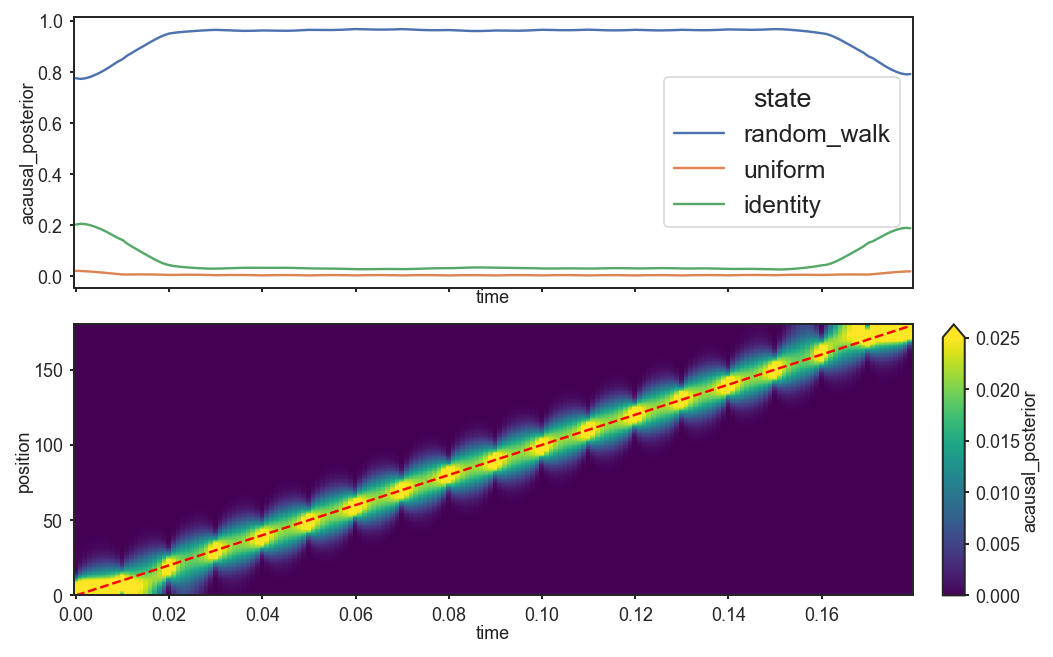

In [272]:
fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True)

results.acausal_posterior.sum("position").plot(x="time", hue="state", ax=axes[0])
results.acausal_posterior.sum("state").plot(
    x="time", y="position", robust=True, ax=axes[1], vmin=0.0,
)
axes[1].plot(results.time, true_replay_position, color="red", linestyle="--")

smoothing over position incorporates more time bins around the line?
+ rho ($\rho$) = magnitude of normal vector
+ phi ($\phi$) or theta ($\theta$)? = angle of normal vector

In [9]:
from skimage.transform import radon

likelihood = results.likelihood.values[:, 0, :]
theta = np.arange(0, 180, 0.5) # degrees
radon_transform = radon(likelihood, theta=theta, circle=False)
score = np.max(radon_transform)

theta_max_ind, rho_max_ind = np.unravel_index(
    np.argmax(radon_transform), radon_transform.shape
)
score /= likelihood.shape[1]

dt = np.mean(np.diff(replay_time))
dp = np.mean(np.diff(classifier.place_bin_centers_.squeeze()))
theta_max = theta[theta_max_ind]
# rho_max = rho[rho_max_ind]

theta = np.arctan(np.tan(theta_max) * dt / dp)
rho # starting_location
theta # velocity
slope = -np.radians(theta) # double check


intercept = rho / np.sin(theta) - slope * midpoint_time + midpoint_position

"""

theta = atan( tan( thetamax ) .* dt./dp );
rho = rhomax .* dt .* cos(theta)./cos(thetamax);

slope = -cot( theta );
intercept = rho ./ sin(theta) - slope.*0.5*(x(1)+x(end)) + 0.5*(y(1)+y(end));
"""

NameError: name 'rho' is not defined

In [10]:
score

1.1219047938836295

In [11]:
slope

NameError: name 'slope' is not defined

In [15]:
theta = np.arange(0, 180, 0.5)  # degrees
theta.shape

(360,)

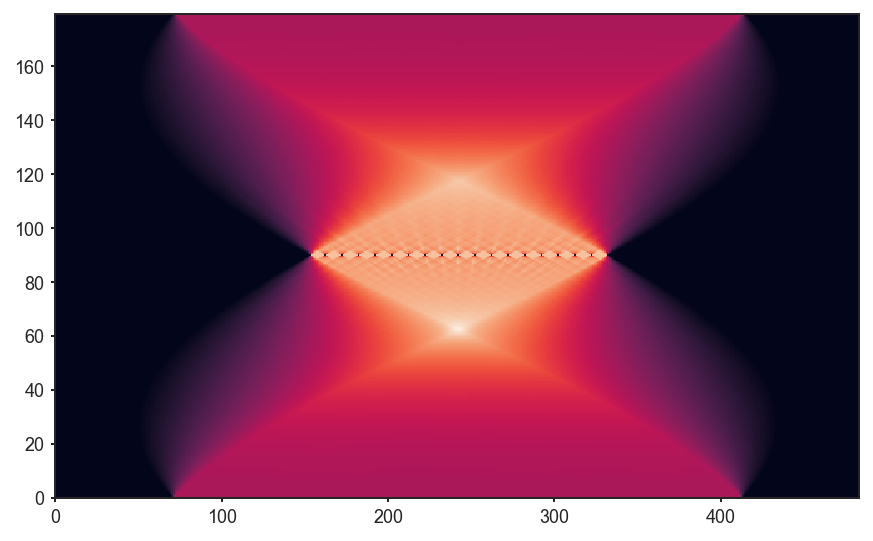

In [16]:
plt.pcolormesh(np.arange(484), theta, radon_transform.T)

TypeError: Dimensions of C (360, 484) are incompatible with X (180) and/or Y (360); see help(pcolormesh)

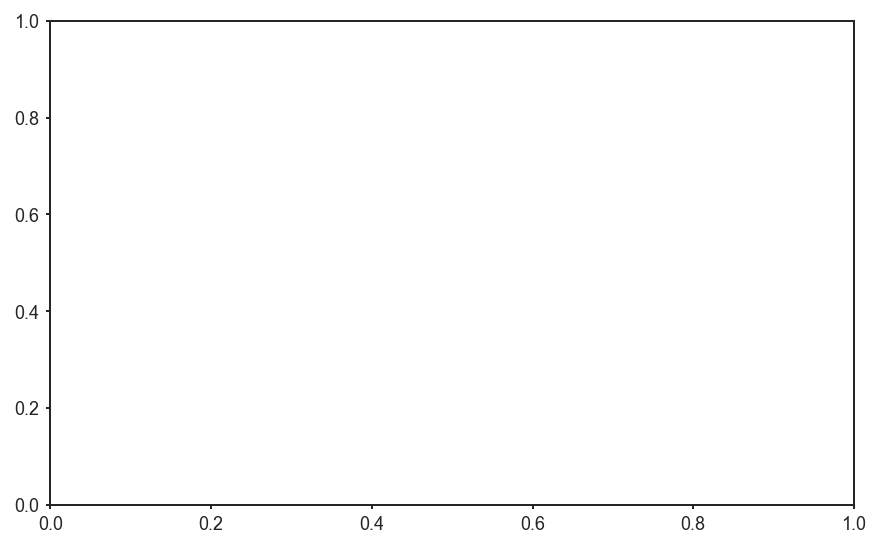

In [17]:
plt.pcolormesh(replay_time, theta, radon_transform.T)
plt.ylabel("time")
plt.ylabel("theta")

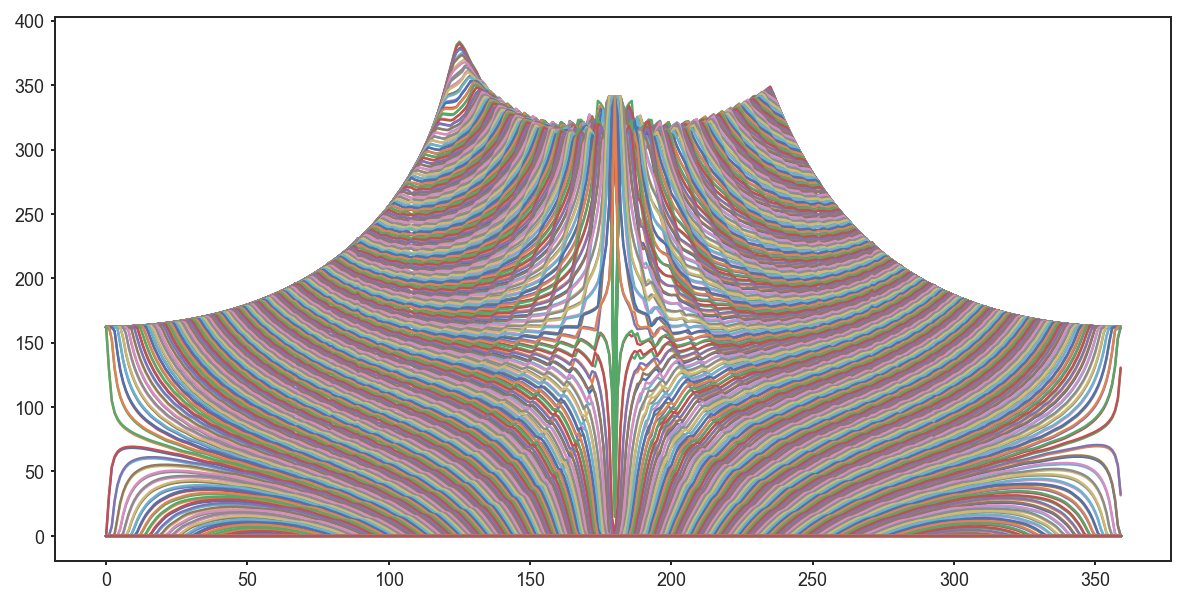

In [18]:
plt.figure(figsize=(10, 5))

for r in radon_transform:
    plt.plot(r)

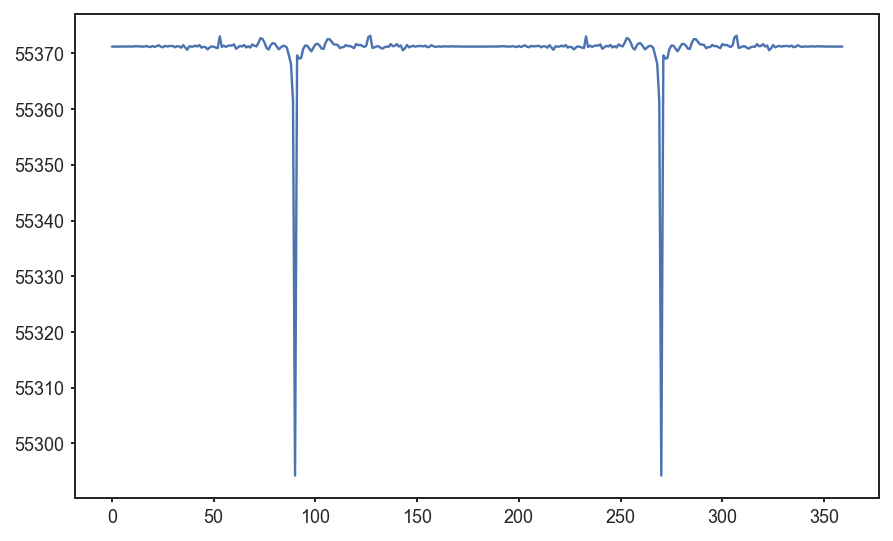

In [19]:
plt.plot(np.sum(radon_transform, axis=0))

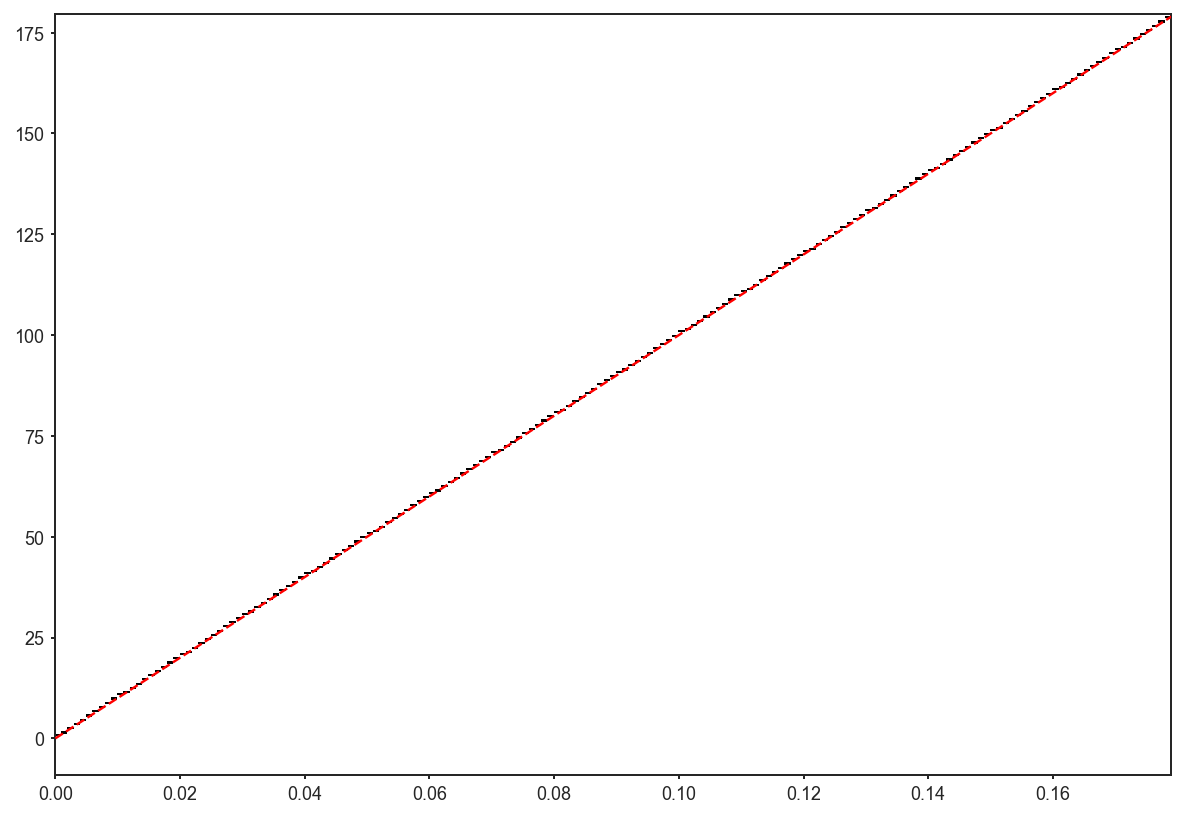

In [196]:
def create_constant_velocity_likelihood(results, true_replay_position, classifier):
    likelihood = np.zeros((len(results.time), len(results.position)))
    p_ind = np.searchsorted(
        classifier.place_bin_edges_.squeeze(), true_replay_position, side="right"
    )
    t_ind = np.arange(len(results.time))
    likelihood[(t_ind, p_ind)] = 1

    return likelihood


likelihood = create_constant_velocity_likelihood(
    results, true_replay_position, classifier
)
x, y = np.meshgrid(results.time, results.position)

plt.figure(figsize=(10, 7))
plt.pcolormesh(x, y, likelihood.T, cmap="bone_r")
plt.plot(replay_time, true_replay_position, zorder=100, color="red", linestyle="--")

The locations of peaks in the transform correspond to the locations of straight lines in the original image.

projection angle = 62 degrees
projection position = 0 pixel from center at 90


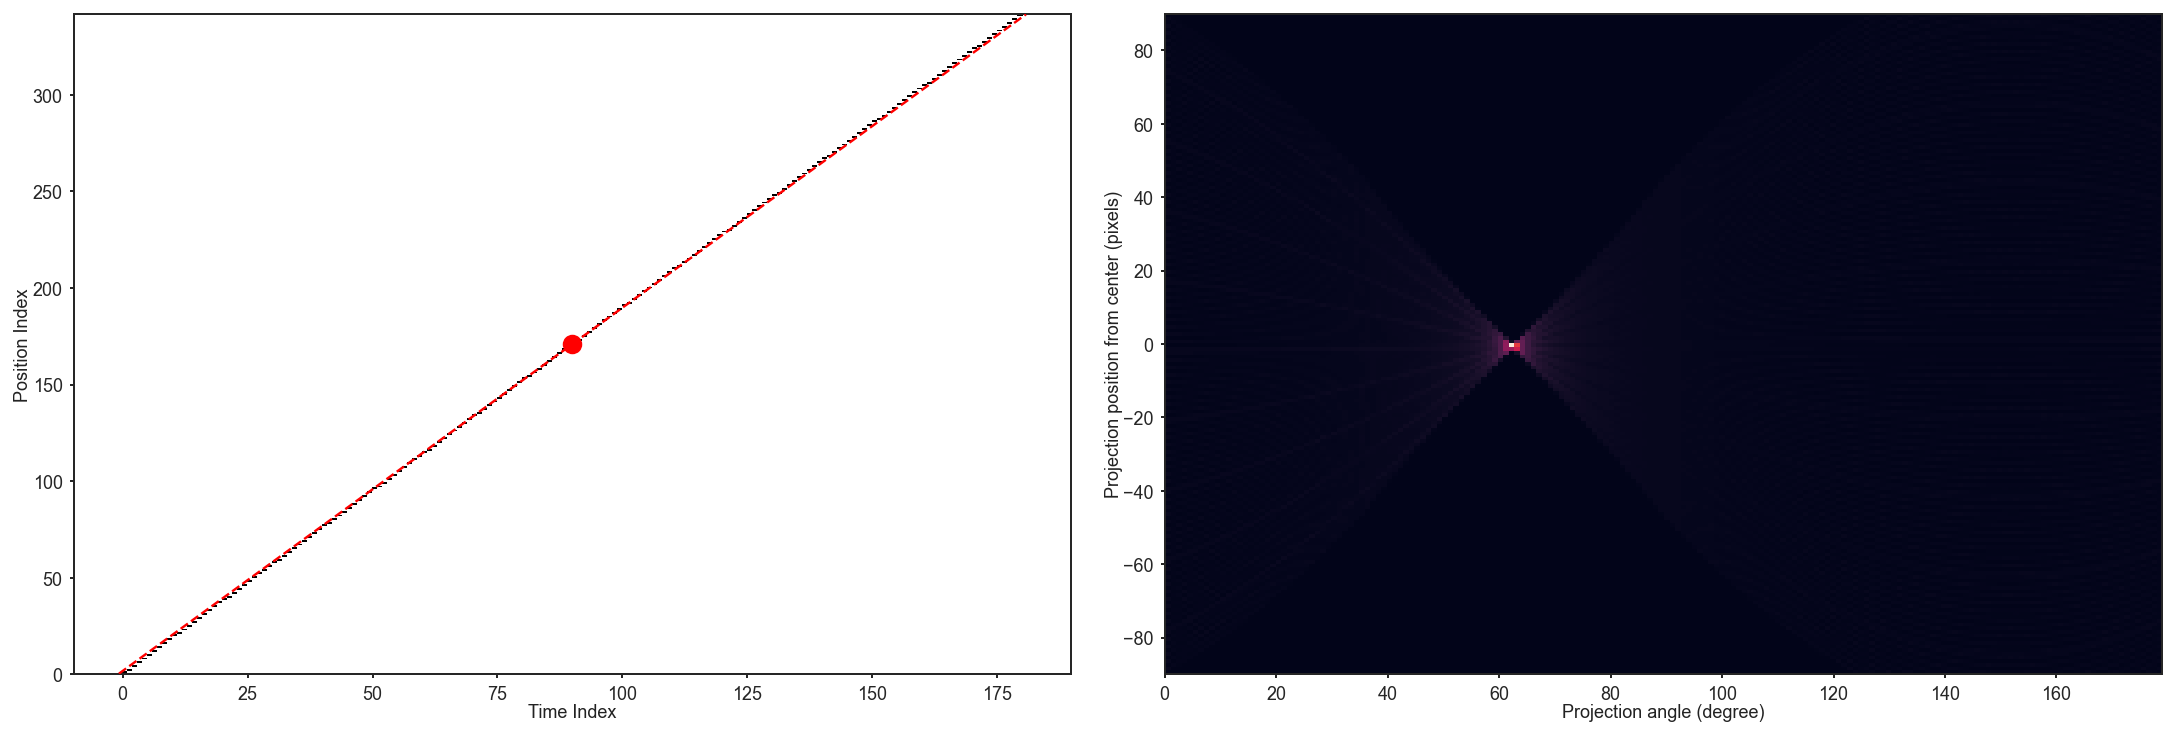

In [249]:
# likelihood = np.fliplr(np.eye(50))
# likelihood = np.zeros((50, 50))
# likelihood[0] = 1
theta = np.arange(0, 180, 1)  # degrees

sinogram = radon(likelihood, theta=theta, circle=True)

fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(15, 5))
center = sinogram.shape[0] // 2

pixels_from_center = np.arange(-center, center)

rotation_axis = likelihood.shape[0] // 2, likelihood.shape[1] // 2

axes[0].pcolormesh(likelihood.T, cmap="bone_r")
axes[0].scatter(
    likelihood.shape[0] // 2, likelihood.shape[1] // 2, zorder=100, color="red", s=80
)
axes[0].set_xlabel("Time Index")
axes[0].set_ylabel("Position Index")

axes[1].imshow(
    sinogram, extent=(theta.min(), theta.max(), -center, center), aspect="auto",
)
axes[1].set_ylabel("Projection position from center (pixels)")
axes[1].set_xlabel("Projection angle (degree)")

rho_max_ind, theta_max_ind = np.unravel_index(np.argmax(sinogram), sinogram.shape)
print(f"projection angle = {theta[theta_max_ind]} degrees")
print(
    f"projection position = {pixels_from_center[rho_max_ind]} pixel from center at {center}"
)

rad_theta_max = np.deg2rad(theta[theta_max_ind])
l = np.sqrt(rotation_axis[0] ** 2 + rotation_axis[1] ** 2)
axes[0].plot(
    (
        rotation_axis[0] - l * np.cos(rad_theta_max),
        rotation_axis[0] + l * np.cos(rad_theta_max),
    ),
    (
        rotation_axis[1] - l * np.sin(rad_theta_max),
        rotation_axis[1] + l * np.sin(rad_theta_max),
    ),
    color="red",
    zorder=100,
    linestyle="--",
)

In [257]:
projection_angle = np.deg2rad(theta[theta_max_ind])
n_pixels_from_center = pixels_from_center[rho_max_ind]
(
    rotation_axis[0] + n_pixels_from_center * np.cos(rad_theta_max),
    rotation_axis[0] + n_pixels_from_center * np.cos(rad_theta_max),
)

(90.0, 90.0)

1.0821041362364843

In [254]:
dt = np.mean(np.diff(results.time))
dp = np.mean(np.diff(results.position))
t = np.arctan(np.tan(np.deg2rad(theta[theta_max_ind])) * dt / dp)
r = pixels_from_center[rho_max_ind] * dt * np.cos(t) / np.cos(theta[theta_max_ind])
-1 / np.tan(t)

-279.8470692955151

In [252]:
r

0.0

In [221]:
rho_max_ind * np.cos(theta[theta_max_ind]), rho_max_ind * np.sin(theta[theta_max_ind])

(60.61564460912276, -66.52626269843006)

In [ ]:
'''
dt = mean( diff( x ) );
dp = mean( diff( y ) );

theta = atan( tan( thetamax ) .* dt./dp );
rho = rhomax .* dt .* cos(theta)./cos(thetamax);

slope = -cot( theta );
intercept = rho ./ sin(theta) - slope.*0.5*(x(1)+x(end)) + 0.5*(y(1)+y(end));
'''

In [209]:
likelihood.shape[1] // 2

171

In [212]:
rotation_axis

(90, 171)

In [211]:
likelihood.shape

(180, 342)

In [64]:
max(likelihood.shape)

50

In [69]:
center = sinogram.shape[0] // 2
center

25

(25, 25)

In [22]:
radon?

Signature: radon(image, theta=None, circle=True, *, preserve_range=None)
Docstring:
Calculates the radon transform of an image given specified
projection angles.

Parameters
----------
image : array_like
    Input image. The rotation axis will be located in the pixel with
    indices ``(image.shape[0] // 2, image.shape[1] // 2)``.
theta : array_like, optional
    Projection angles (in degrees). If `None`, the value is set to
    np.arange(180).
circle : boolean, optional
    Assume image is zero outside the inscribed circle, making the
    width of each projection (the first dimension of the sinogram)
    equal to ``min(image.shape)``.
preserve_range : bool, optional
    Whether to keep the original range of values. Otherwise, the input
    image is converted according to the conventions of `img_as_float`.
    Also see https://scikit-image.org/docs/dev/user_guide/data_types.html

Returns
-------
radon_image : ndarray
    Radon transform (sinogram).  The tomography rotation axis will li